<a href="https://colab.research.google.com/github/dreamboysatvik/HYBRID-MODEL-FOR-STOCK-MARKET/blob/main/Sparks_task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [61]:
# -*- coding: utf-8 -*-
"""
Created on Sun Jul  4 16:42:26 2021

@author: hp
"""

#Series analysis
import os
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
from statsmodels.tsa.stattools import adfuller, acf, pacf
#ARIMA is used to understand past data or predict future data in a series.
from statsmodels.tsa.arima_model import ARIMA
import nltk
import re
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('vader_lexicon')
# TEXTBLOB IS part-of-speech tagging, noun phrase extraction, sentiment analysis, classification, translation, and more
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem.porter import PorterStemmer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
import xgboost 
import lightgbm





[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


        Date     Open     High      Low    Close
0  04-Jan-01  4180.97  4180.97  4109.55  4115.37
1  05-Jan-01  4116.34  4195.01  4115.35  4183.73
2  08-Jan-01  4164.76  4206.72  4101.53  4120.43
3  09-Jan-01  4114.74  4166.84  4101.01  4125.31
4  10-Jan-01  4151.58  4155.86  4035.44  4047.64
(5097, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5097 entries, 0 to 5096
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    5097 non-null   datetime64[ns]
 1   Open    5097 non-null   float64       
 2   High    5097 non-null   float64       
 3   Low     5097 non-null   float64       
 4   Close   5097 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 199.2 KB


Text(0, 0.5, 'Close')

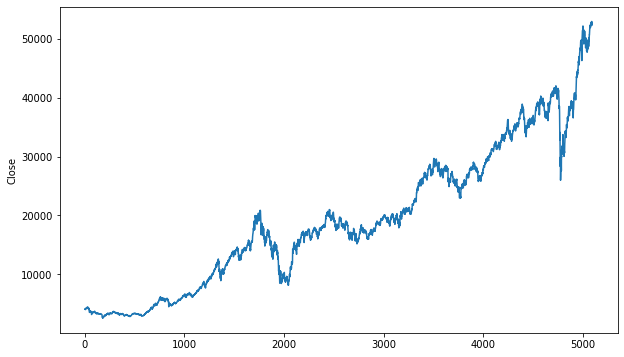

In [62]:
df_prices = pd.read_csv("BSESN.csv")
print(df_prices.head())
print(df_prices.shape)
      
df_prices["Date"] = pd.to_datetime(df_prices["Date"])
df_prices.info()

df_prices.dropna(inplace = True)

plt.figure(figsize=(10, 6))
df_prices['Close'].plot()
plt.ylabel('Close')



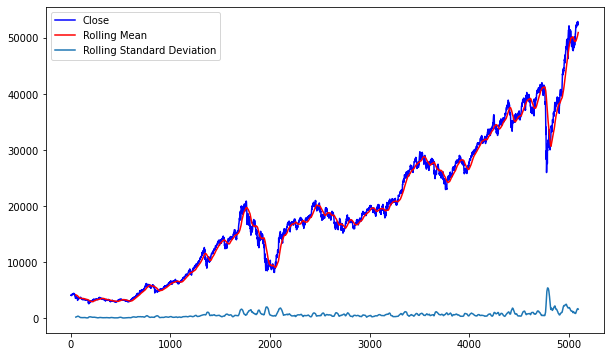

In [63]:
#Plotting moving average
close = df_prices['Close']
ma = close.rolling(window = 50).mean()
std = close.rolling(window = 50).std()

plt.figure(figsize=(10, 6))
df_prices['Close'].plot(color = 'b', label = 'Close')
ma.plot(color = 'r', label = 'Rolling Mean')
std.plot(label = 'Rolling Standard Deviation')
plt.legend()



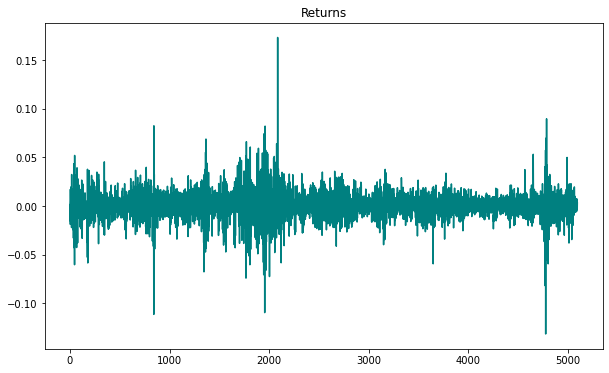

In [64]:

#Plotting returns
returns = close / close.shift(1) - 1

plt.figure(figsize = (10,6))
returns.plot(label='Return', color = 'teal')
plt.title("Returns")


train = df_prices[:4000]
test = df_prices[4000:]



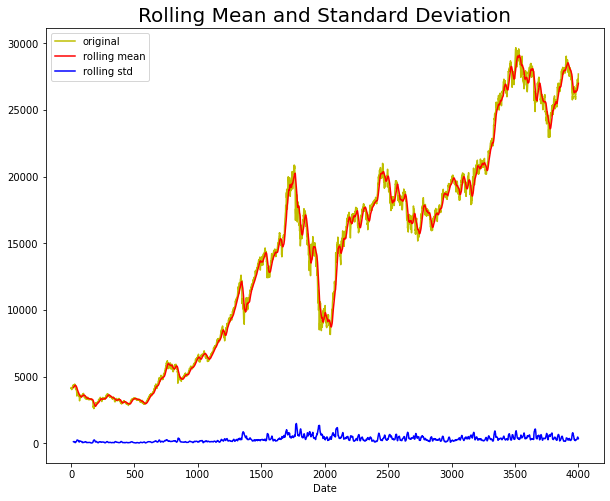

Results of dickey fuller test
ADF Test Statistic : -0.4991917532026632
p-value : 0.8921741240563106
#Lags Used : 14
Number of Observations Used : 3985
Weak evidence against null hypothesis, time series is non-stationary 


In [65]:
#Stationarity test
def test_stationarity(timeseries):

 #Determing rolling statistics
 rolmean = timeseries.rolling(20).mean()
 rolstd = timeseries.rolling(20).std()

 #Plot rolling statistics:
 plt.figure(figsize = (10,8))
 plt.plot(timeseries, color = 'y', label = 'original')
 plt.plot(rolmean, color = 'r', label = 'rolling mean')
 plt.plot(rolstd, color = 'b', label = 'rolling std')
 plt.xlabel('Date')
 plt.legend()
 plt.title('Rolling Mean and Standard Deviation',  fontsize = 20)
 plt.show(block = False)
 
 print('Results of dickey fuller test')
 result = adfuller(timeseries, autolag = 'AIC')
 labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
 for value,label in zip(result, labels):
   print(label+' : '+str(value) )
 if result[1] <= 0.05:
   print("Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
 else:
   print("Weak evidence against null hypothesis, time series is non-stationary ")
test_stationarity(train['Close'])



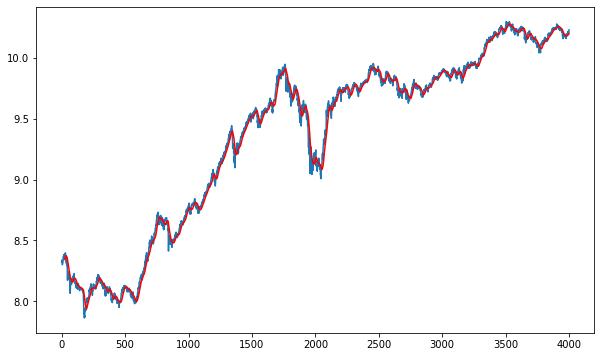

In [66]:

train_log = np.log(train['Close']) 
test_log = np.log(test['Close'])

mav = train_log.rolling(24).mean() 
plt.figure(figsize = (10,6))
plt.plot(train_log) 
plt.plot(mav, color = 'red')




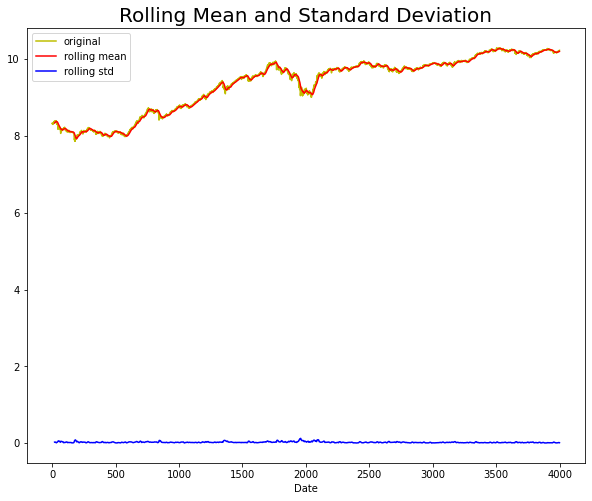

Results of dickey fuller test
ADF Test Statistic : -0.8758768446383587
p-value : 0.7958126935391578
#Lags Used : 14
Number of Observations Used : 3985
Weak evidence against null hypothesis, time series is non-stationary 


In [68]:
train_log.dropna(inplace = True)
test_log.dropna(inplace = True)

test_stationarity(train_log)




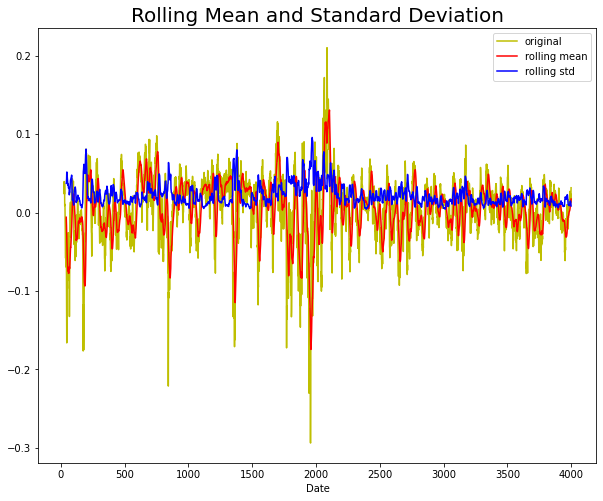

Results of dickey fuller test
ADF Test Statistic : -9.377403738069972
p-value : 7.106134739839854e-16
#Lags Used : 26
Number of Observations Used : 3950
Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary


In [69]:
train_log_diff = train_log - mav
train_log_diff.dropna(inplace = True)

test_stationarity(train_log_diff)



Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-22436.086, Time=2.37 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-22409.824, Time=0.53 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-22431.057, Time=0.51 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-22433.519, Time=1.19 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-22407.606, Time=0.23 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-22438.169, Time=1.87 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-22439.680, Time=1.03 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-22438.143, Time=2.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-22437.482, Time=0.80 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-22436.103, Time=2.79 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-22437.707, Time=0.32 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 13.741 seconds
RMSE :  0.09901747466935151


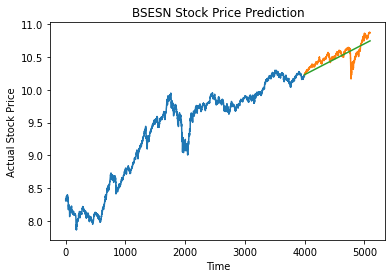

In [70]:
#Using auto arima to make predictions using log data
from pmdarima import auto_arima
model = auto_arima(train_log, trace = True, error_action = 'ignore', suppress_warnings = True)
model.fit(train_log)
predictions = model.predict(n_periods = len(test))
predictions = pd.DataFrame(predictions,index = test_log.index,columns=['Prediction'])


plt.plot(train_log, label='Train')
plt.plot(test_log, label='Test')
plt.plot(predictions, label='Prediction')
plt.title('BSESN Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')


#Calculating error
rms = np.sqrt(mean_squared_error(test_log,predictions))
print("RMSE : ", rms)

In [ ]:
#textual analysis


cols = ['Date','Category','News']
df_news = pd.read_csv('india-news-headlines.csv', names = cols)
df_news




,Date,Category,News
0,publish_date,headline_category,headline_text
1,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
2,20010102,unknown,Fissures in Hurriyat over Pak visit
3,20010102,unknown,America's unwanted heading for India?
4,20010102,unknown,For bigwigs; it is destination Goa
...,...,...,...
2294216,20151231,city.bhubaneswar,BJP cadres ransack pension venue
2294217,20151231,unknown,Highest paid TV actors
2294218,20151231,unknown,Malaika's sexy work out regime
2294219,20151231,top-headlines,News brief: 'High time India; Pak end hostilit...


In [ ]:
df_news.drop(0, inplace=True)
df_news.drop('Category', axis = 1, inplace=True)
df_news.info()



<class 'pandas.core.frame.DataFrame'>
Int64Index: 2294220 entries, 1 to 2294220
Data columns (total 2 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   Date    object
 1   News    object
dtypes: object(2)
memory usage: 52.5+ MB


In [ ]:
df_news['Date'] = pd.to_datetime(df_news['Date'],format= '%Y%m%d')
df_news= df_news.replace(np.nan, '', regex=True)
df_news


,Date,News
1,2001-01-02,Status quo will not be disturbed at Ayodhya; s...
2,2001-01-02,Fissures in Hurriyat over Pak visit
3,2001-01-02,America's unwanted heading for India?
4,2001-01-02,For bigwigs; it is destination Goa
5,2001-01-02,Extra buses to clear tourist traffic
...,...,...
2294216,2015-12-31,BJP cadres ransack pension venue
2294217,2015-12-31,Highest paid TV actors
2294218,2015-12-31,Malaika's sexy work out regime
2294219,2015-12-31,News brief: 'High time India; Pak end hostilit...


In [ ]:

df_news['News'] = df_news.groupby(['Date'])["News"].transform(lambda x : ' '.join(x)) 
df_news = df_news.drop_duplicates() 
df_news.reset_index(inplace = True, drop = True)
df_news




,Date,News
0,2001-01-02,Status quo will not be disturbed at Ayodhya; s...
1,2001-01-03,Powerless north India gropes in the dark Think...
2,2001-01-04,The string that pulled Stephen Hawking to Indi...
3,2001-01-05,Light combat craft takes India into club class...
4,2001-01-06,Light combat craft takes India into club class...
...,...,...
5430,2015-12-27,Why mother's touch is so soothing Salman Khan:...
5431,2015-12-28,8 common sexual fetishes 15 best healthy cooki...
5432,2015-12-29,5 confusing healthy habits 2nd ODI: Afghanista...
5433,2015-12-30,Tips to handle late-night partying Tips to avo...


In [ ]:

#Cleaning headlines
c = []
for i in range(0,len(df_news['News'])):
    news = re.sub('[^a-zA-Z]',' ',df_news['News'][i])
    news = news.lower()
    news = news.split()
    ps=PorterStemmer()
    news = [ps.stem(word) for word in news if not word in set(stopwords.words('english'))]
    news=' '.join(news)
    c.append(news)

In [ ]:
df_news['News'] = pd.Series(c)
df_news

,Date,News
0,2001-01-02,statu quo disturb ayodhya say vajpaye fissur h...
1,2001-01-03,powerless north india grope dark think laxman ...
2,2001-01-04,string pull stephen hawk india vajpaye give bi...
3,2001-01-05,light combat craft take india club class hawk ...
4,2001-01-06,light combat craft take india club class hawk ...
...,...,...
5430,2015-12-27,mother touch sooth salman khan clich make film...
5431,2015-12-28,common sexual fetish best healthi cook oil ind...
5432,2015-12-29,confus healthi habit nd odi afghanistan vs zim...
5433,2015-12-30,tip handl late night parti tip avoid red lipst...


In [ ]:
#Functions to get the subjectivity and polarity
def getSubjectivity(text):
  return TextBlob(text).sentiment.subjectivity

def getPolarity(text):
  return  TextBlob(text).sentiment.polarity

In [ ]:

#Adding subjectivity and polarity columns
df_news['Subjectivity'] = df_news['News'].apply(getSubjectivity)
df_news['Polarity'] = df_news['News'].apply(getPolarity)
df_news

,Date,News,Subjectivity,Polarity
0,2001-01-02,statu quo disturb ayodhya say vajpaye fissur h...,0.298148,0.099074
1,2001-01-03,powerless north india grope dark think laxman ...,0.429167,0.025000
2,2001-01-04,string pull stephen hawk india vajpaye give bi...,0.475140,0.032481
3,2001-01-05,light combat craft take india club class hawk ...,0.458412,0.296404
4,2001-01-06,light combat craft take india club class hawk ...,0.425758,0.389394
...,...,...,...,...
5430,2015-12-27,mother touch sooth salman khan clich make film...,0.419260,0.064392
5431,2015-12-28,common sexual fetish best healthi cook oil ind...,0.409842,0.075807
5432,2015-12-29,confus healthi habit nd odi afghanistan vs zim...,0.440270,0.036626
5433,2015-12-30,tip handl late night parti tip avoid red lipst...,0.435480,0.108731


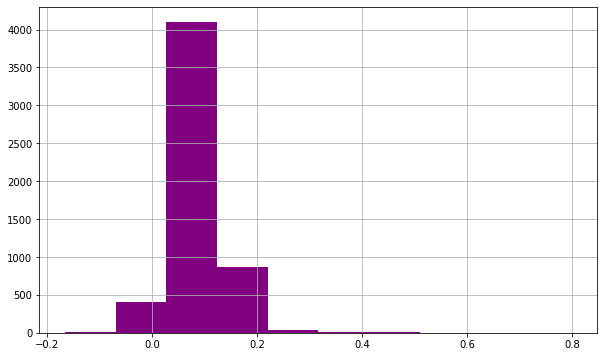

In [ ]:
plt.figure(figsize = (10,6))
df_news['Polarity'].hist(color = 'purple')

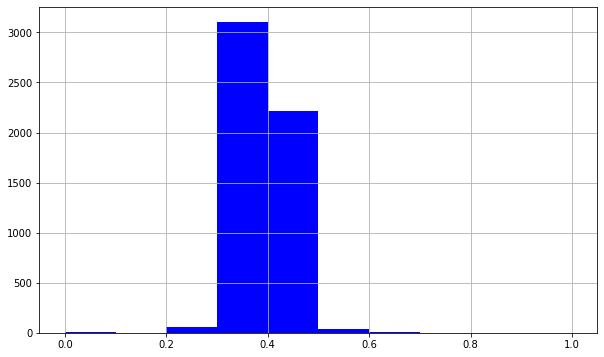

In [ ]:
plt.figure(figsize = (10,6))
df_news['Subjectivity'].hist(color = 'blue')

In [ ]:
#Adding sentiment score to df_news
sia = SentimentIntensityAnalyzer()

df_news['Compound'] = [sia.polarity_scores(v)['compound'] for v in df_news['News']]
df_news['Negative'] = [sia.polarity_scores(v)['neg'] for v in df_news['News']]
df_news['Neutral'] = [sia.polarity_scores(v)['neu'] for v in df_news['News']]
df_news['Positive'] = [sia.polarity_scores(v)['pos'] for v in df_news['News']]
df_news

,Date,News,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,2001-01-02,statu quo disturb ayodhya say vajpaye fissur h...,0.298148,0.099074,-0.8555,0.125,0.773,0.102
1,2001-01-03,powerless north india grope dark think laxman ...,0.429167,0.025000,-0.5994,0.132,0.755,0.113
2,2001-01-04,string pull stephen hawk india vajpaye give bi...,0.475140,0.032481,0.9169,0.099,0.791,0.110
3,2001-01-05,light combat craft take india club class hawk ...,0.458412,0.296404,-0.3612,0.171,0.659,0.170
4,2001-01-06,light combat craft take india club class hawk ...,0.425758,0.389394,-0.7579,0.207,0.649,0.144
...,...,...,...,...,...,...,...,...
5430,2015-12-27,mother touch sooth salman khan clich make film...,0.419260,0.064392,-0.9997,0.133,0.777,0.091
5431,2015-12-28,common sexual fetish best healthi cook oil ind...,0.409842,0.075807,-0.9996,0.136,0.765,0.099
5432,2015-12-29,confus healthi habit nd odi afghanistan vs zim...,0.440270,0.036626,-0.9999,0.151,0.765,0.085
5433,2015-12-30,tip handl late night parti tip avoid red lipst...,0.435480,0.108731,-0.9993,0.132,0.763,0.106


In [40]:
df_merge = pd.merge(df_prices, df_news, how='inner', on='Date')
df_merge

,Date,Open,High,Low,Close,News,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,2001-01-04,4180.97,4180.97,4109.55,4115.37,string pull stephen hawk india vajpaye give bi...,0.475140,0.032481,0.9169,0.099,0.791,0.110
1,2001-01-05,4116.34,4195.01,4115.35,4183.73,light combat craft take india club class hawk ...,0.458412,0.296404,-0.3612,0.171,0.659,0.170
2,2001-01-08,4164.76,4206.72,4101.53,4120.43,sangh parivar babri panel ant frontrunn key us...,0.486204,-0.035142,-0.6808,0.100,0.816,0.084
3,2001-01-09,4114.74,4166.84,4101.01,4125.31,financi bharat shah held alleg link chotta sha...,0.453860,0.057229,-0.9928,0.141,0.813,0.047
4,2001-01-10,4151.58,4155.86,4035.44,4047.64,fend pand tell doctor bureaucraci undermin leg...,0.000000,0.000000,0.0000,0.000,1.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...
3701,2015-12-24,25893.84,25922.47,25763.40,25838.71,perfect run form simpl breath exercis reduc an...,0.408666,0.071771,-0.9988,0.122,0.778,0.101
3702,2015-12-28,25858.52,26073.41,25856.86,26034.13,common sexual fetish best healthi cook oil ind...,0.409842,0.075807,-0.9996,0.136,0.765,0.099
3703,2015-12-29,26075.68,26133.78,25994.45,26079.48,confus healthi habit nd odi afghanistan vs zim...,0.440270,0.036626,-0.9999,0.151,0.765,0.085
3704,2015-12-30,26123.87,26130.20,25939.25,25960.03,tip handl late night parti tip avoid red lipst...,0.435480,0.108731,-0.9993,0.132,0.763,0.106


In [41]:
df = df_merge[['Close','Subjectivity', 'Polarity', 'Compound', 'Negative', 'Neutral' ,'Positive']]
df

,Close,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,4115.37,0.475140,0.032481,0.9169,0.099,0.791,0.110
1,4183.73,0.458412,0.296404,-0.3612,0.171,0.659,0.170
2,4120.43,0.486204,-0.035142,-0.6808,0.100,0.816,0.084
3,4125.31,0.453860,0.057229,-0.9928,0.141,0.813,0.047
4,4047.64,0.000000,0.000000,0.0000,0.000,1.000,0.000
...,...,...,...,...,...,...,...
3701,25838.71,0.408666,0.071771,-0.9988,0.122,0.778,0.101
3702,26034.13,0.409842,0.075807,-0.9996,0.136,0.765,0.099
3703,26079.48,0.440270,0.036626,-0.9999,0.151,0.765,0.085
3704,25960.03,0.435480,0.108731,-0.9993,0.132,0.763,0.106


In [60]:

from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
new_df = pd.DataFrame(sc.fit_transform(df))
new_df.columns = df.columns
new_df.index = df.index
new_df.head()
new_df.tail()

,Close,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
3701,0.858094,0.408666,0.361316,0.00060,0.373089,0.706349,0.133598
3702,0.865310,0.409842,0.367694,0.00020,0.415902,0.689153,0.130952
3703,0.866984,0.440270,0.305775,0.00005,0.461774,0.689153,0.112434
3704,0.862573,0.435480,0.419725,0.00035,0.403670,0.686508,0.140212
3705,0.868389,0.401180,0.354215,0.00020,0.486239,0.675926,0.112434


In [43]:
X = new_df.drop('Close', axis=1)
y =new_df['Close']

In [44]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 0)
x_train.shape

(2964, 6)

In [45]:
rf = RandomForestRegressor()
rf.fit(x_train, y_train)
prediction=rf.predict(x_test)

In [46]:
print(prediction[:10])
print(y_test[:10])
print(mean_squared_error(prediction,y_test))

[0.18533249 0.5833114  0.74537504 0.25180616 0.21061057 0.10918056
 0.13367947 0.1629954  0.51272638 0.14909353]
1032    0.144401
3033    0.583950
2797    0.542869
2060    0.411216
1366    0.288590
1544    0.398202
748     0.123687
45      0.043871
2148    0.521363
1082    0.153538
Name: Close, dtype: float64
0.03539248362156796


In [47]:

adb = AdaBoostRegressor()
adb.fit(x_train, y_train)
predictions = adb.predict(x_test)

In [48]:
print(mean_squared_error(predictions, y_test))

0.043233988559477715


In [49]:
from sklearn.tree import DecisionTreeRegressor
dec_tree = DecisionTreeRegressor()
dec_tree.fit(x_train, y_train)
predictions = dec_tree.predict(x_test)

In [50]:
print(predictions[:10])
print(y_test[:10])
print(mean_squared_error(predictions,y_test))

[0.19189968 0.54552511 0.93542232 0.01265285 0.13949409 0.03708267
 0.34169742 0.08396571 0.56176415 0.02390512]
1032    0.144401
3033    0.583950
2797    0.542869
2060    0.411216
1366    0.288590
1544    0.398202
748     0.123687
45      0.043871
2148    0.521363
1082    0.153538
Name: Close, dtype: float64
0.06442163705135617


In [51]:
lgb = lightgbm.LGBMRegressor()
lgb.fit(x_train, y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [52]:
predictions = lgb.predict(x_test)
print(mean_squared_error(predictions,y_test))

0.03593414361086365


In [55]:
xgb = xgboost.XGBRegressor()
xgb.fit(x_train, y_train)

[16:00:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [56]:
predictions = xgb.predict(x_test)
print(mean_squared_error(predictions,y_test))

0.03667322773124939


**We see XgBoost, lightgbm and RandomForest works best in predicting stock's close value using sentimental data as input.**